<a href="https://colab.research.google.com/github/And0k/jupyter-space/blob/main/%D0%9A%D0%BE%D1%80%D0%B6_%D0%90_%D0%9C%D0%98%D0%98_%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%81%D1%8A%D0%B5%D0%B4%D0%BE%D0%B1%D0%BD%D1%8B%D1%85_%D0%B4%D0%B8%D0%BA%D0%BE%D1%80%D0%B0%D1%81%D1%82%D1%83%D1%89%D0%B8%D1%85_%D1%80%D0%B0%D1%81%D1%82%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [110]:
import plotly.express as px  # Library that generates interactive web-based visualizations.

In [111]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [112]:
# Define dataset and metadata file names and paths
dataset_package_name = "gverzea/edible-wild-plants"
metadata_file = "edible wild plants metadata.xls"
my_drive_dest = "drive/My Drive/Colab Notebooks/Методы ИИ"

# Extract dataset stem from dataset name
dataset_package_stem = dataset_package_name.split('/', 1)[-1]
dataset_package_path = rf'{my_drive_dest}/{dataset_package_stem}'

# Загрузка датасета с Kaggle и копирование на Google Диск (при первом запуске)
(you'll need press button to select and upload kaggle.json from you local computer if interaction with Kaggle will be needed)

In [113]:
# Check if metadata file exists, if not, download and extract dataset
metadata_path = f'{dataset_package_path}/{metadata_file}'
if not os.path.exists(metadata_path):
    dataset_package_zip = f"{dataset_package_stem}.zip"  # file name that appears to be downloaded after downloading dataset
    dataset_package_zip_path = rf'{my_drive_dest}/{dataset_package_zip}'
    if not os.path.exists(dataset_package_zip_path):
        my_drive_dest_for_cmd = my_drive_dest.replace(' ', '\ ')

        # Kaggle access file (from my_drive_dest or upload)
        if not os.path.exists(os.path.expanduser('~/.kaggle/kaggle.json')):
            !mkdir ~/.kaggle
            if os.path.exists(rf'{my_drive_dest}/kaggle.json'):
                !cp $my_drive_dest_for_cmd/kaggle.json ~/.kaggle/
            else:
                print("Select kaggle.json to dounload to Google Colab")
                from google.colab import files
                uploaded = files.upload()
                !cp kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json

        # Dataset zip file (autoskipping if exist)
        !kaggle datasets download $dataset_package_name -p $my_drive_dest_for_cmd

    import zipfile

    with zipfile.ZipFile(dataset_package_zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_package_path)

# # Directory to extract the contents
# extract_path = 'dataset_package_folder'

# # Create the extraction directory if it doesn't exist
# os.makedirs(extract_path, exist_ok=True)

# # Extract the zip file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# Просмотр состава данных

In [114]:
# Load metadata from Excel file
df_in = pd.read_excel(metadata_path)
df_in.set_index("Name", inplace=True)
print(df_in)

                    Nr  # pics    Scientific name  \
Name                                                
Alfalfa              9      50    Medicago sativa   
Asparagus            5     100          Asparagus   
Blue Vervain        46      50    Verbena hastata   
Broadleaf Plantain  10      50     Plantago major   
Bull Thistle         8      50    Cirsium vulgare   
...                 ..     ...                ...   
Wild Bee Balm       36      50  Monarda fistulosa   
Wild Black Cherry   14      50    Prunus serotina   
Wild Grape Vine     35     100      Vitis riparia   
Wild Leek           43     100   Allium tricoccum   
Wood Sorrel          7      50  Oxalis acetosella   

                                                          Description  
Name                                                                   
Alfalfa             A flowering plant in the pea family, Alfalfa i...  
Asparagus           Asparagus, easily identified by its fleshy gre...  
Blue Vervain        Yo

In [115]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
import random
from PIL import Image

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet18

# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


# Проверка наличия изображений данных в ожидаемых директориях и отображение сетки изображений

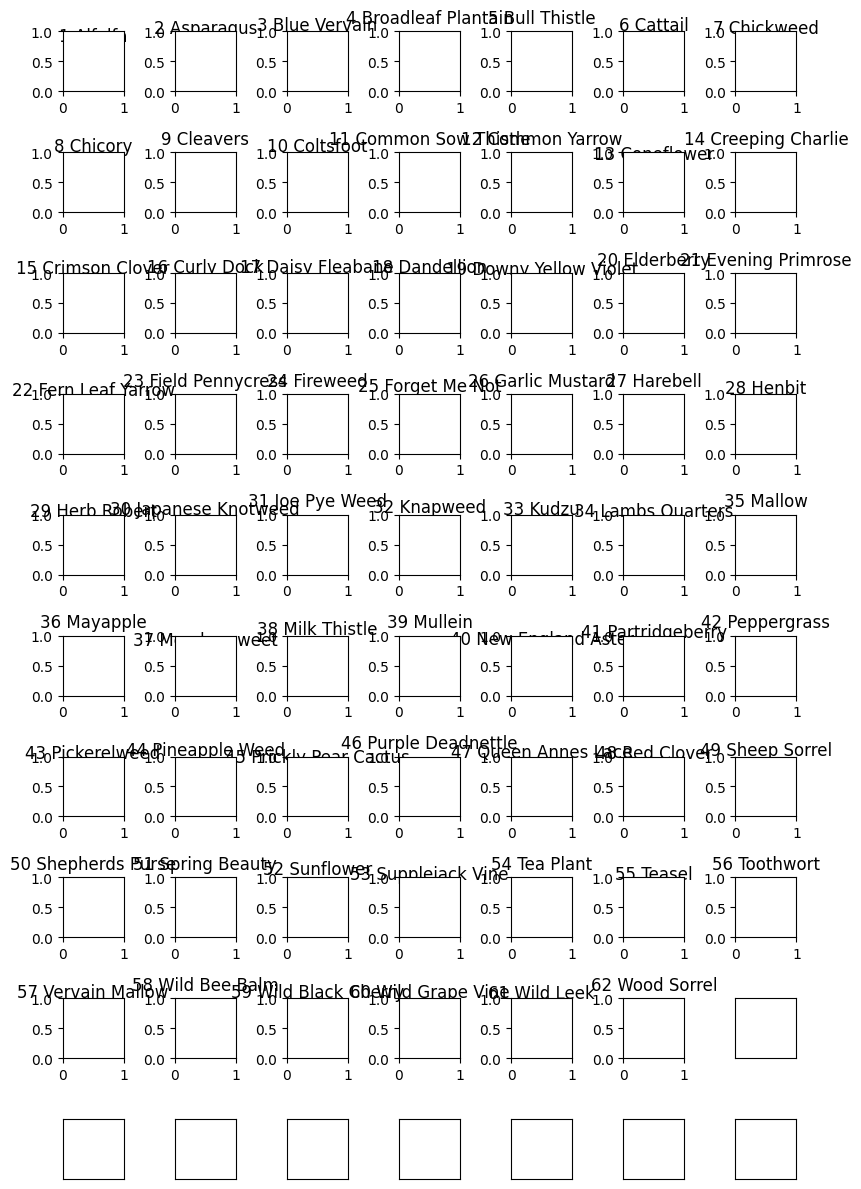

classes found: 62


In [116]:
# Check if images are available in the expected directories
def check_images_availability(datasets_root):
    subfolders = ['dataset', 'dataset-test', 'dataset-user_images']
    for subfolder in subfolders:
        subfolder_path = os.path.join(datasets_root, subfolder)
        if not os.path.exists(subfolder_path):
            print(f"Directory {subfolder_path} does not exist.")
            return False
        if not os.listdir(subfolder_path):
            print(f"Directory {subfolder_path} is empty.")
            return False
    return True

# Draw a grid of one image for each class
def draw_image_grid(datasets_root):
    classes = os.listdir(os.path.join(datasets_root, 'dataset'))
    num_classes = len(classes)
    n_rows = 10
    n_cols = int(np.ceil(num_classes / n_rows))
    figure, axes = plt.subplots(n_rows, n_cols, figsize=(8, 12),
                                subplot_kw={'xticks': [], 'yticks': []})
    for i, (ax, cls) in enumerate(zip(axes.flat, classes), start=1):
        figure.add_subplot(n_rows, n_cols, i)
        class_path = os.path.join(datasets_root, 'dataset', cls)
        image_file = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, image_file)
        image = Image.open(image_path)
        ax.imshow(image)
        ax.set_title(f'{i} {cls}')  #  if i % 2 else f'{cls}\n{i}'
        ax.axis('off')
        # print(image_file, end= " " if i % n_cols else "\n")
    plt.tight_layout()
    plt.show()
    return num_classes

# Check images availability and draw grid
datasets_path = f'{dataset_package_path}/datasets'
if check_images_availability(datasets_path):
    num_classes = draw_image_grid(datasets_path)
    print('classes found:', num_classes)
else:
    print("Images are not available in the expected directories.")

# Создание своего класса PyTorch.Dataset для загрузки данных в PyTorch

In [131]:


class DatasetE(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_paths = glob.glob(f'{root_dir}/**/*.jpg')  # , recursive=True
        if any(self.image_paths):
            # have folders with images
            labels = [path.rsplit('/', 2)[1] for path in self.image_paths]
            try:
                self.labels = torch.tensor(df_in.loc[labels, 'Nr'].values)  # Convert labels to indices
            except KeyError:
                self.labels = [None for i in labels]
        else:
            # some images in folder (without labels)
            self.image_paths = glob.glob(f'{root_dir}/*.jpg')
            self.labels = [None for i in self.image_paths]
            return

        # self.labels = torch.tensor(self.labels)  # Convert labels to tensor
        # self.label_to_idx = df_in.loc[labels, 'Nr']  # mapping from label to index

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

# Предобработка изображений

In [118]:
from torchvision.transforms import v2

# Define the data transformations
data_transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),  # Randomly crop and resize images to 224x224 pixels with antialiasing
    v2.RandomHorizontalFlip(),  # Randomly flip images horizontally
    v2.RandomRotation(10),  # Randomly rotate images by 10 degrees
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),  # Convert images to PyTorch tensors
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images with mean and std
])

# Разделение датасета на обучающую и тестовую выборки

In [121]:
# Split dataset into training and testing sets
dataset = DatasetE(root_dir=f'{datasets_path}/dataset', transform=data_transforms)
train_indices, test_indices = train_test_split(
    list(range(len(dataset))), test_size=0.2, random_state=1
)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Примеры трансформированных рис. из папки dataset-user_images

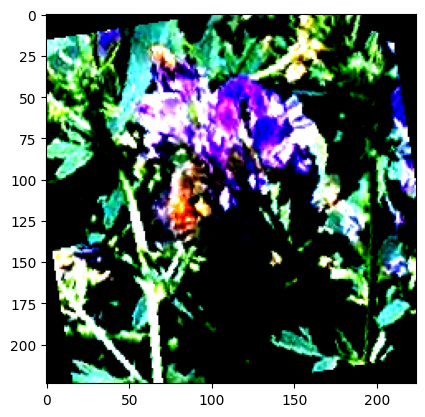

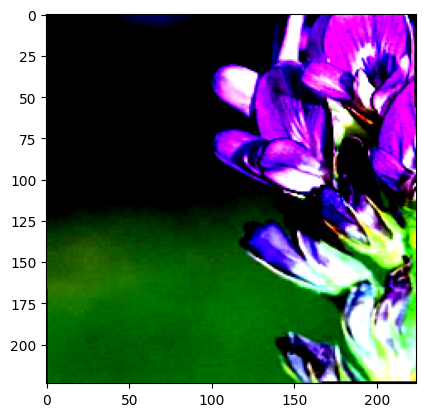

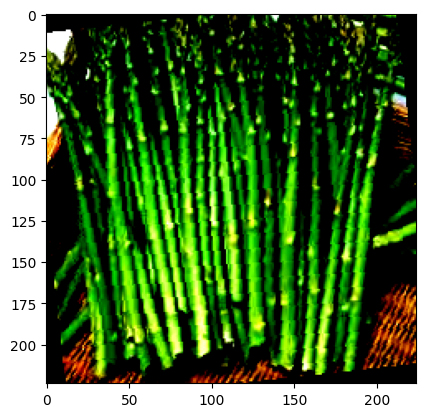

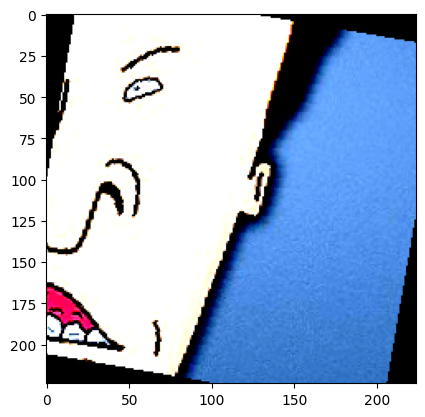

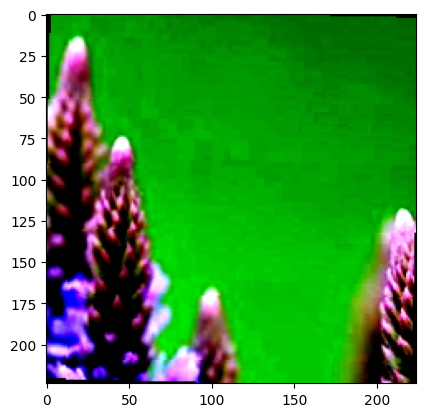

In [132]:
# Load and display examples from user images dataset
user_images_dataset = DatasetE(
    root_dir=f'{datasets_path}/dataset-user_images',
    transform=data_transforms
)

for i in range(5):
    image, label = user_images_dataset[i]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(label)
    plt.show()

# Обучение модели распознавания

In [134]:
# Define the model
model = resnet18(weights='DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(
    num_ftrs, len(os.listdir(os.path.join(datasets_path, 'dataset')))
)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}')

# Save the trained model
torch.save(model.state_dict(), os.path.join(dataset_package_path, 'my_model_weights.pth'))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
